#Хід роботи

## Налаштування робочого середовища

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## Завантаження набору даних FashionMNIST

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [ ]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

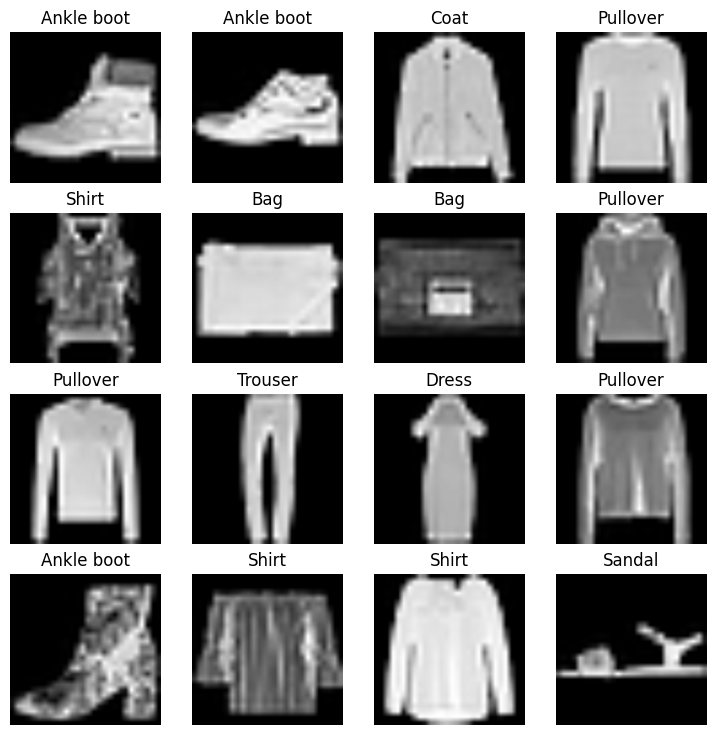

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Розділимо  набір даних на вибірки: тренувальну, валідаційну, тестову та розмічені і нерозмічені аибірки

In [ ]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Divide the dataset into label and unlabel sets
label_data = int(0.3 * len(train_dataset))
unlabel_data = len(train_dataset) - label_data
label_dataset, unlabel_dataset = torch.utils.data.random_split(train_dataset, [label_data, unlabel_data])

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
label_dataloader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)
unlabel_dataloader = DataLoader(unlabel_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_dataloader)*BATCH_SIZE}")
print(f"Label images: {len(label_dataloader)* BATCH_SIZE}")
print(f"Unlabel images: {len(unlabel_dataloader)* BATCH_SIZE}")
print(f"Valid images: {len(valid_dataloader)* BATCH_SIZE}")
print(f"Test images: {len(test_dataloader)* BATCH_SIZE}")

Length of train dataloader: 48000
Label images: 14400
Unlabel images: 33600
Valid images: 12000
Test images: 10016


## Навчання моделі

In [ ]:
def train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, epochs, device):
    # Dictionary to store results
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate through the training dataloader
        for inputs, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_dataloader)
        train_acc = 100 * correct_train / total_train

        # Store training results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        # Iterate through the validation dataloader
        with torch.no_grad():
            for inputs, labels in tqdm(valid_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation metrics
        val_loss = running_loss / len(valid_dataloader)
        val_acc = 100 * correct_val / total_val

        # Store validation results
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Print epoch-wise training and validation metrics
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return results


In [ ]:
def plot_model(history):
  train_accs, val_accs, train_losses, val_losses = history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_acc'], label='Train')
  plt.plot(history['val_acc'], label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_loss'], label='Train')
  plt.plot(history['val_loss'], label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [ ]:
# Download and configure EfficientNet
efficientnet_model = models.efficientnet_b0(pretrained=False)
efficientnet_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
efficientnet_model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True),
                                                    torch.nn.Linear(in_features=1280,
                                                                    out_features=len(class_names), # same number of output units as our number of classes
                                                                    bias=True)).to(device)
efficientnet_model.to(device)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=efficientnet_model,
        input_size=(32, 1, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

results = train(model=efficientnet_model,
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

Epoch 1/15 - Validation: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


Epoch [1/15] - Train Loss: 0.4966, Train Accuracy: 81.89% - Validation Loss: 0.3433, Validation Accuracy: 88.03%


Epoch 2/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


Epoch [2/15] - Train Loss: 0.3138, Train Accuracy: 88.77% - Validation Loss: 0.2587, Validation Accuracy: 91.05%


Epoch 3/15 - Validation: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


Epoch [3/15] - Train Loss: 0.2583, Train Accuracy: 90.76% - Validation Loss: 0.2396, Validation Accuracy: 91.50%


Epoch 4/15 - Validation: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


Epoch [4/15] - Train Loss: 0.2257, Train Accuracy: 91.84% - Validation Loss: 0.2179, Validation Accuracy: 92.03%


Epoch 5/15 - Validation: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


Epoch [5/15] - Train Loss: 0.2013, Train Accuracy: 92.61% - Validation Loss: 0.2439, Validation Accuracy: 91.84%


Epoch 6/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


Epoch [6/15] - Train Loss: 0.1881, Train Accuracy: 93.23% - Validation Loss: 0.2317, Validation Accuracy: 91.38%


Epoch 7/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


Epoch [7/15] - Train Loss: 0.1668, Train Accuracy: 93.88% - Validation Loss: 0.1929, Validation Accuracy: 93.20%


Epoch 8/15 - Validation: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


Epoch [8/15] - Train Loss: 0.1523, Train Accuracy: 94.42% - Validation Loss: 0.2216, Validation Accuracy: 92.73%


Epoch 9/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


Epoch [9/15] - Train Loss: 0.1385, Train Accuracy: 95.05% - Validation Loss: 0.2299, Validation Accuracy: 92.80%


Epoch 10/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


Epoch [10/15] - Train Loss: 0.1239, Train Accuracy: 95.50% - Validation Loss: 0.1996, Validation Accuracy: 93.46%


Epoch 11/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


Epoch [11/15] - Train Loss: 0.1097, Train Accuracy: 96.03% - Validation Loss: 0.2050, Validation Accuracy: 93.56%


Epoch 12/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


Epoch [12/15] - Train Loss: 0.0980, Train Accuracy: 96.46% - Validation Loss: 0.2100, Validation Accuracy: 92.98%


Epoch 13/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


Epoch [13/15] - Train Loss: 0.0855, Train Accuracy: 96.92% - Validation Loss: 0.2054, Validation Accuracy: 93.47%


Epoch 14/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


Epoch [14/15] - Train Loss: 0.0787, Train Accuracy: 97.15% - Validation Loss: 0.2235, Validation Accuracy: 93.49%


Epoch 15/15 - Validation: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]

Epoch [15/15] - Train Loss: 0.0681, Train Accuracy: 97.53% - Validation Loss: 0.2309, Validation Accuracy: 93.62%


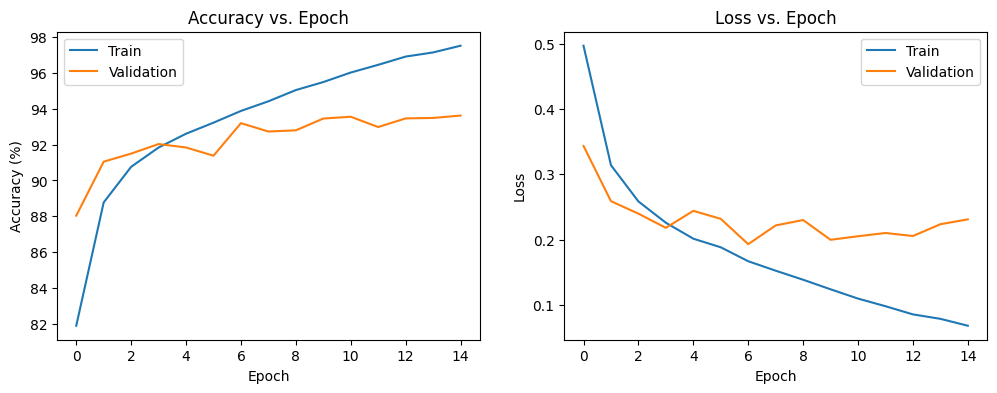

In [ ]:
plot_model(results)

## 7. Збережемо ваги навченої нейронної мережі у файл

In [ ]:
torch.save(efficientnet_model.state_dict(), 'model_all_data.pth')

## 8. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці.

In [ ]:
# Define the custom dataset to include pseudo-labels
class CombineDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset, pseudo_labels):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.labeled_dataset) + len(self.unlabeled_dataset)

    def __getitem__(self, index):
        if index < len(self.labeled_dataset):
            return self.labeled_dataset[index]
        else:
            # Adjust the index for the unlabeled data
            unlabeled_index = index - len(self.labeled_dataset)
            unlabeled_data, _ = self.unlabeled_dataset[unlabeled_index]
            pseudo_label = self.pseudo_labels[unlabeled_index]
            return unlabeled_data, pseudo_label

In [ ]:
def democrat_co_train(model1, model2, label_dataloader, unlabel_dataloader, valid_dataloader,
                      optimizer1, optimizer2, loss_fn, epochs, device):

    results = {"train_loss1": [],
              "train_acc1": [],
              "train_loss2": [],
              "train_acc2": [],
              "val_loss1": [],
              "val_acc1": [],
              "val_loss2": [],
              "val_acc2": []
              }

    # Training the models using co-training
    for epoch in range(epochs):
        model1.train()
        model2.train()

        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_train1 = 0
        correct_train2 = 0
        total_train1 = 0
        total_train2 = 0

        print(f"Epoch [{epoch + 1}/{epochs}]")
        for labeled_data, labels in tqdm(label_dataloader):
            labeled_data, labels = labeled_data.to(device), labels.to(device)
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # Train model1 with labeled data
            outputs1 = model1(labeled_data)
            loss1 = loss_fn(outputs1, labels)
            loss1.backward()
            optimizer1.step()

            # Train model2 with labeled data
            outputs2 = model2(labeled_data)
            loss2 = loss_fn(outputs2, labels)
            loss2.backward()
            optimizer2.step()

            running_loss1 += loss1.item()
            running_loss2 += loss2.item()

            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)

            total_train1 += labels.size(0)
            total_train2 += labels.size(0)

            correct_train1 += (predicted1 == labels).sum().item()
            correct_train2 += (predicted2 == labels).sum().item()

        train_loss1 = running_loss1 / len(label_dataloader)
        train_loss2 = running_loss2 / len(label_dataloader)

        train_acc1 = 100 * correct_train1 / total_train1
        train_acc2 = 100 * correct_train2 / total_train2

        results["train_loss1"].append(train_loss1)
        results["train_acc1"].append(train_acc1)
        results["train_loss2"].append(train_loss2)
        results["train_acc2"].append(train_acc2)

        # Pseudo-label unlabeled data
        model1.eval()
        model2.eval()

        pseudo_labels1 = []
        pseudo_labels2 = []

        for data_unlabeled, _ in unlabel_dataloader:
            with torch.no_grad():
                data_unlabeled = data_unlabeled.to(device)
                outputs1 = model1(data_unlabeled)
                outputs2 = model2(data_unlabeled)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                pseudo_labels1.extend(predicted1.tolist())
                pseudo_labels2.extend(predicted2.tolist())

        # Concatenate the labeled and unlabeled data using the custom dataset
        combined_dataset1 = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels1)
        combined_dataset2 = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels2)

        combined_dataloader1 = DataLoader(combined_dataset1, batch_size=BATCH_SIZE, shuffle=True)
        combined_dataloader2 = DataLoader(combined_dataset2, batch_size=BATCH_SIZE, shuffle=True)

        model1.train()
        model2.train()
        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_train1 = 0
        correct_train2 = 0
        total_train = 0

        for (data1, labels1), (data2, labels2) in tqdm(zip(combined_dataloader1, combined_dataloader2)):
            data1, labels1 = data1.to(device), labels1.to(device)
            data2, labels2 = data2.to(device), labels2.to(device)

            # Train the first view model on combine dataset from second view model
            optimizer1.zero_grad()
            outputs1 = model1(data2)
            loss1 = loss_fn(outputs1, labels2)
            loss1.backward()
            optimizer1.step()

            # Train the second view model on combine dataset from first view model
            optimizer2.zero_grad()
            outputs2 = model2(data1)
            loss2 = loss_fn(outputs2, labels1)
            loss2.backward()
            optimizer2.step()

        # Validation
        model1.eval()
        model2.eval()
        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_val1 = 0
        correct_val2 = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs1 = model1(inputs)
                outputs2 = model2(inputs)
                loss1 = loss_fn(outputs1, labels)
                loss2 = loss_fn(outputs2, labels)
                running_loss1 += loss1.item()
                running_loss2 += loss2.item()

                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                total_val += labels.size(0)
                correct_val1 += (predicted1 == labels).sum().item()
                correct_val2 += (predicted2 == labels).sum().item()

        val_loss1 = running_loss1 / len(valid_dataloader)
        val_loss2 = running_loss2 / len(valid_dataloader)
        val_acc1 = 100 * correct_val1 / total_val
        val_acc2 = 100 * correct_val2 / total_val

        results["val_loss1"].append(val_loss1)
        results["val_acc1"].append(val_acc1)
        results["val_loss2"].append(val_loss2)
        results["val_acc2"].append(val_acc2)

        print(f"Model 1: Train: Loss: {train_loss1:.4f}, Accuracy: {train_acc1:.2f}% - "
              f"Validation: Loss: {val_loss1:.4f}, Accuracy: {val_acc1:.2f}%")
        print(f"Model 2: Train: Loss: {train_loss2:.4f}, Accuracy: {train_acc2:.2f}% - "
              f"Validation: Loss: {val_loss2:.4f}, Accuracy: {val_acc2:.2f}%")

    return results

In [ ]:
# Download and configure AlexNet
model_net1 = models.alexnet(pretrained=False)
model_net1.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model_net1.classifier[6]=nn.Linear(4096, len(class_names))
model_net1.to(device)

# Download and configure EfficientNet
model_net2 = models.efficientnet_b0(pretrained=False)
model_net2.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
model_net2.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True),
                                                    torch.nn.Linear(in_features=1280,
                                                                    out_features=len(class_names), # same number of output units as our number of classes
                                                                    bias=True)).to(device)
model_net2.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model_net1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model_net2.parameters(), lr=0.001)

results = democrat_co_train(model1=model_net1,
                   model2=model_net2,
                   label_dataloader=label_dataloader,
                   unlabel_dataloader=unlabel_dataloader,
                   valid_dataloader=valid_dataloader,
                   optimizer1=optimizer1,
                   optimizer2=optimizer2,
                   loss_fn=loss_fn,
                   epochs=15,
                   device=device)

Epoch [1/15]


100%|██████████| 450/450 [01:34<00:00,  4.75it/s]
1500it [04:45,  5.26it/s]


Model 1: Train: Loss: 0.9406, Accuracy: 63.85% - Validation: Loss: 0.4575, Accuracy: 82.25%
Model 2: Train: Loss: 0.8423, Accuracy: 69.06% - Validation: Loss: 0.6041, Accuracy: 79.11%
Epoch [2/15]


100%|██████████| 450/450 [01:37<00:00,  4.63it/s]
1500it [04:46,  5.23it/s]


Model 1: Train: Loss: 0.4338, Accuracy: 83.88% - Validation: Loss: 0.4189, Accuracy: 85.75%
Model 2: Train: Loss: 0.3871, Accuracy: 85.49% - Validation: Loss: 0.3804, Accuracy: 86.90%
Epoch [3/15]


100%|██████████| 450/450 [01:37<00:00,  4.60it/s]
1500it [04:48,  5.21it/s]


Model 1: Train: Loss: 0.3818, Accuracy: 85.78% - Validation: Loss: 0.3399, Accuracy: 88.03%
Model 2: Train: Loss: 0.2966, Accuracy: 89.33% - Validation: Loss: 0.3857, Accuracy: 87.40%
Epoch [4/15]


100%|██████████| 450/450 [01:38<00:00,  4.59it/s]
1500it [04:45,  5.24it/s]


Model 1: Train: Loss: 0.3432, Accuracy: 87.22% - Validation: Loss: 0.3293, Accuracy: 88.18%
Model 2: Train: Loss: 0.2558, Accuracy: 90.67% - Validation: Loss: 0.3092, Accuracy: 89.00%
Epoch [5/15]


100%|██████████| 450/450 [01:38<00:00,  4.59it/s]
1500it [04:48,  5.20it/s]


Model 1: Train: Loss: 0.3119, Accuracy: 88.44% - Validation: Loss: 0.3511, Accuracy: 87.76%
Model 2: Train: Loss: 0.2249, Accuracy: 91.79% - Validation: Loss: 0.2694, Accuracy: 90.53%
Epoch [6/15]


100%|██████████| 450/450 [01:37<00:00,  4.59it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2866, Accuracy: 89.57% - Validation: Loss: 0.3175, Accuracy: 89.04%
Model 2: Train: Loss: 0.1873, Accuracy: 93.16% - Validation: Loss: 0.2902, Accuracy: 90.39%
Epoch [7/15]


100%|██████████| 450/450 [01:37<00:00,  4.60it/s]
1500it [04:48,  5.21it/s]


Model 1: Train: Loss: 0.2709, Accuracy: 89.97% - Validation: Loss: 0.3061, Accuracy: 89.45%
Model 2: Train: Loss: 0.1641, Accuracy: 93.90% - Validation: Loss: 0.2984, Accuracy: 90.05%
Epoch [8/15]


100%|██████████| 450/450 [01:37<00:00,  4.61it/s]
1500it [04:48,  5.20it/s]


Model 1: Train: Loss: 0.2558, Accuracy: 90.42% - Validation: Loss: 0.2808, Accuracy: 90.03%
Model 2: Train: Loss: 0.1414, Accuracy: 94.99% - Validation: Loss: 0.2449, Accuracy: 91.83%
Epoch [9/15]


100%|██████████| 450/450 [01:37<00:00,  4.60it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2472, Accuracy: 90.76% - Validation: Loss: 0.3068, Accuracy: 89.53%
Model 2: Train: Loss: 0.1103, Accuracy: 95.97% - Validation: Loss: 0.2717, Accuracy: 91.40%
Epoch [10/15]


100%|██████████| 450/450 [01:37<00:00,  4.61it/s]
1500it [04:47,  5.21it/s]


Model 1: Train: Loss: 0.2370, Accuracy: 91.36% - Validation: Loss: 0.2838, Accuracy: 90.18%
Model 2: Train: Loss: 0.0902, Accuracy: 96.75% - Validation: Loss: 0.2625, Accuracy: 91.31%
Epoch [11/15]


100%|██████████| 450/450 [01:37<00:00,  4.62it/s]
1500it [04:47,  5.21it/s]


Model 1: Train: Loss: 0.2265, Accuracy: 91.52% - Validation: Loss: 0.2873, Accuracy: 90.09%
Model 2: Train: Loss: 0.0679, Accuracy: 97.49% - Validation: Loss: 0.2583, Accuracy: 91.85%
Epoch [12/15]


100%|██████████| 450/450 [01:37<00:00,  4.61it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2231, Accuracy: 91.52% - Validation: Loss: 0.2789, Accuracy: 90.11%
Model 2: Train: Loss: 0.0578, Accuracy: 98.06% - Validation: Loss: 0.2606, Accuracy: 91.53%
Epoch [13/15]


100%|██████████| 450/450 [01:37<00:00,  4.63it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2145, Accuracy: 91.87% - Validation: Loss: 0.2636, Accuracy: 90.78%
Model 2: Train: Loss: 0.0456, Accuracy: 98.47% - Validation: Loss: 0.2718, Accuracy: 91.24%
Epoch [14/15]


100%|██████████| 450/450 [01:37<00:00,  4.64it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2111, Accuracy: 92.10% - Validation: Loss: 0.2906, Accuracy: 90.37%
Model 2: Train: Loss: 0.0319, Accuracy: 99.00% - Validation: Loss: 0.2798, Accuracy: 91.25%
Epoch [15/15]


100%|██████████| 450/450 [01:37<00:00,  4.63it/s]
1500it [04:47,  5.22it/s]


Model 1: Train: Loss: 0.2020, Accuracy: 92.44% - Validation: Loss: 0.2815, Accuracy: 90.24%
Model 2: Train: Loss: 0.0296, Accuracy: 99.04% - Validation: Loss: 0.2795, Accuracy: 91.82%


In [ ]:
def plot_co_model(history):
  plt.figure(figsize=(24, 10))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_acc1'], label='Train view 1')
  plt.plot(history['val_acc1'], label='Validation view 1')
  plt.plot(history['train_acc2'], label='Train view 2')
  plt.plot(history['val_acc2'], label='Validation view 2')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_loss1'], label='Train view 1')
  plt.plot(history['val_loss1'], label='Validation view 1')
  plt.plot(history['train_loss2'], label='Train view 2')
  plt.plot(history['val_loss2'], label='Validation view 2')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

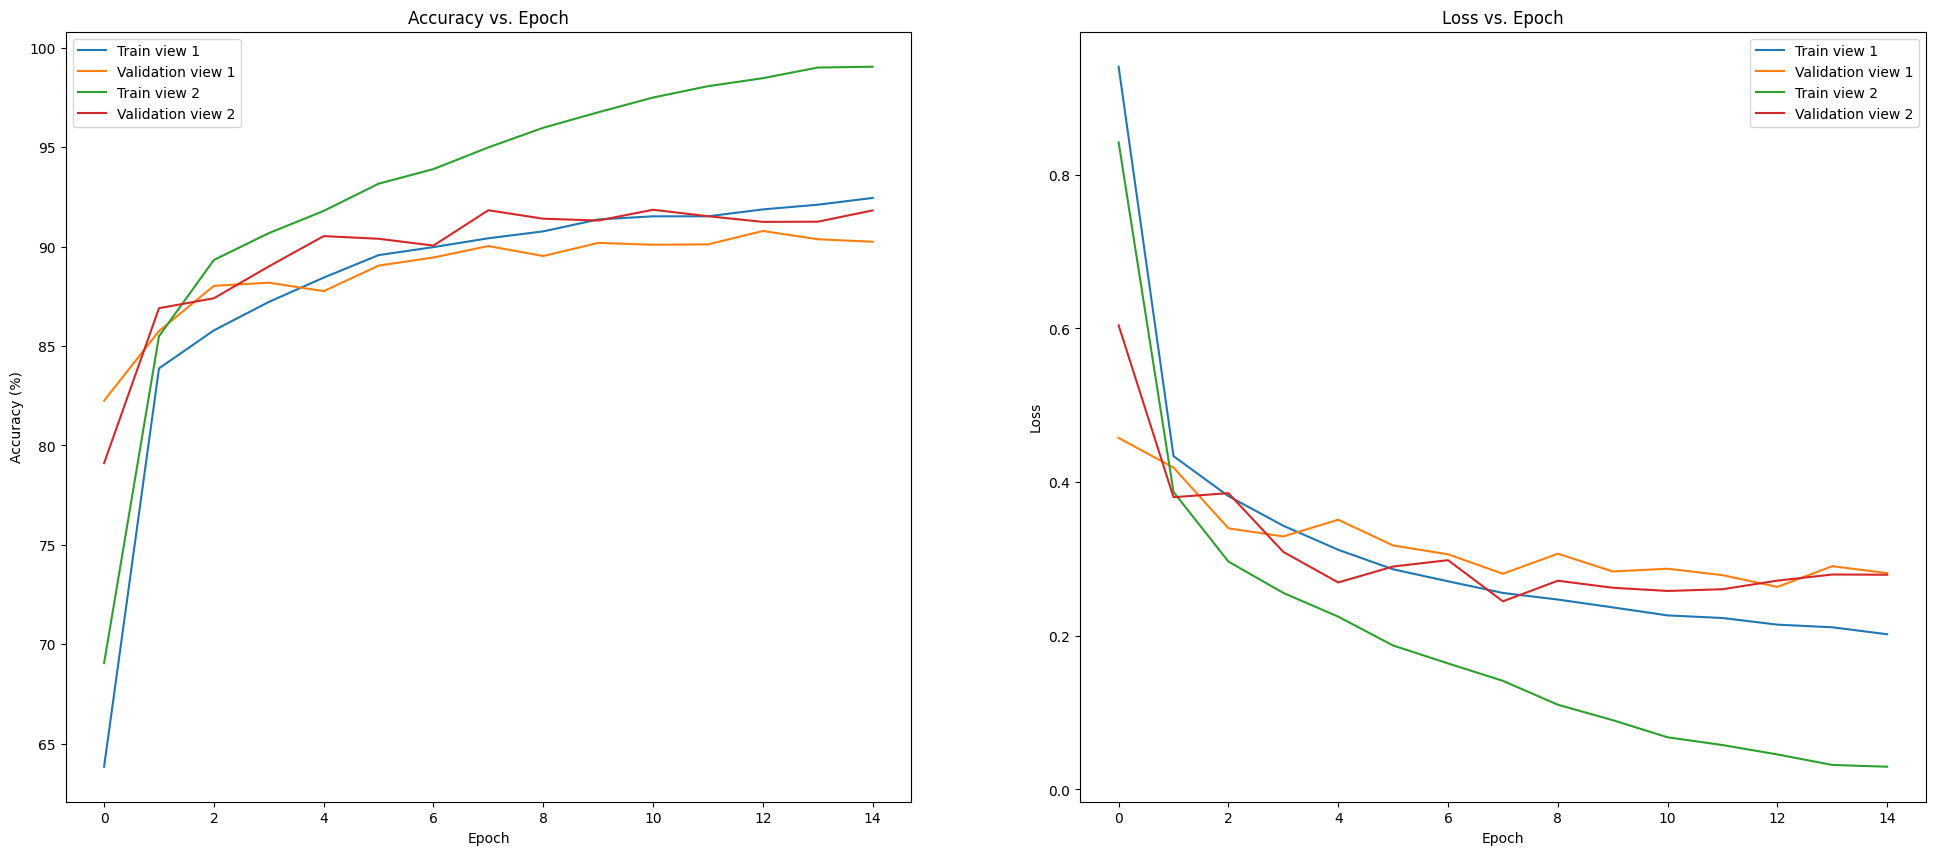

In [ ]:
plot_co_model(results)

In [ ]:
torch.save(model_net1.state_dict(), 'model_1.pth')
torch.save(model_net2.state_dict(), 'model_2.pth')

# Висновок


У даному дослідженні ми досліджували концепцію напівконтрольованого навчання, який представляє собою потужний підхід до машинного навчання. Цей метод використовує як позначені, так і непозначені дані для тренування моделі. Наш підхід включав використання простої репрезентативної моделі, яку ми тренували за допомогою алгоритму democratic-co-train, використовуючи як позначені, так і непозначені дані.

Проведений аналіз результатів показав, що при навчанні на повному наборі даних точність моделі становила 93.62%, тоді як при напівконтрольованому навчанні вона складала 91.82%.